### Importar Libs

In [1]:
import os
import subprocess
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import re

import feature_engine
from feature_engine.encoding import CountFrequencyEncoder, RareLabelEncoder
from feature_engine.datetime import DatetimeFeatures

import category_encoders
from category_encoders.cat_boost import CatBoostEncoder

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

import kds

import sys
sys.path.append("VennABERS")
import VennABERS

In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2023-09-20T21:27:11.534539-03:00

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.15.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [4]:
%watermark --iversions

re               : 2.2.1
category_encoders: 2.6.2
feature_engine   : 1.6.1
kds              : 0.1.3
numpy            : 1.25.2
pandas           : 2.1.0
sys              : 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
matplotlib       : 3.7.2
sklearn          : 1.3.0
seaborn          : 0.12.2



### Variaveis de Ambiente

In [5]:
path_dados = 'Superstore-Marketing-Campaign/'
data = 'superstore_data.csv'

### Importar Dados

In [6]:
df_superstore = pd.read_csv(path_dados + data, sep = ',')
df_superstore.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.000,0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.000,0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.000,0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.000,1,1,11/5/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.000,1,0,8/4/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0


In [7]:
print(df_superstore.shape)

(2240, 22)


In [8]:
df_superstore.columns

Index(['Id', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Response', 'Complain'], dtype='object')

In [9]:
df_superstore.dtypes

Id                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
dtype: object

### Pré-Processamento

In [10]:
# Criando Target e Features
y = df_superstore['Response']
X = df_superstore.drop(['Response', 'Id'], axis = 1)

print(len(X), len(y))

2240 2240


In [11]:
# Separar Treino/Teste/Calibração
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=1000, random_state=13)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=600, random_state=13)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=600, random_state=13)

print(len(X_train), len(X_test), len(X_calib), len(X_new))

1000 600 600 40


In [12]:
print(np.mean(y_train), np.mean(y_test), np.mean(y_calib), np.mean(y_new))

0.156 0.155 0.12833333333333333 0.2


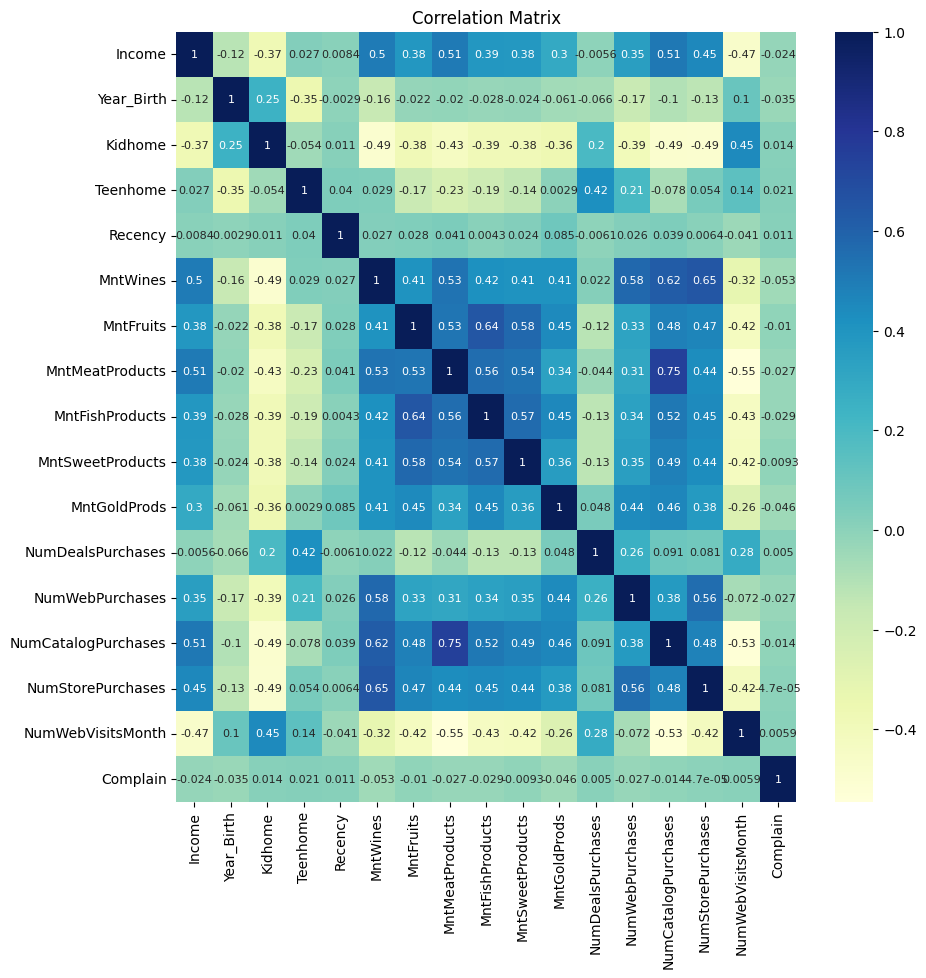

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(X_train[['Income', 'Year_Birth', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                     'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth','Complain']].corr(),
            annot=True,
            cmap="YlGnBu",
            annot_kws={"fontsize":8});
plt.title('Correlation Matrix')
plt.show()

In [14]:
num_cols =  ['Income', 'Year_Birth', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
             'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
             'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth','Complain']
X_train[num_cols]

,Income,Year_Birth,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain
2183,49669.000,1974,1,0,97,166,5,107,11,8,29,2,5,1,6,6,0
34,18351.000,1990,0,0,1,1,12,9,0,14,7,1,2,0,3,7,0
171,30522.000,1960,0,1,6,179,8,83,19,11,26,5,1,2,9,2,0
98,80011.000,1980,0,1,3,421,76,536,82,178,102,2,8,6,5,4,0
631,20180.000,1976,0,0,27,18,42,24,15,20,18,1,2,1,4,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,51124.000,1955,1,1,79,26,1,11,0,1,4,2,1,0,3,3,0
866,69759.000,1966,0,0,38,452,20,514,13,30,0,3,4,6,5,3,0
74,76445.000,1971,1,0,2,739,107,309,140,80,35,1,2,5,13,6,0
2224,44794.000,1966,0,1,99,54,0,7,0,0,4,1,2,0,3,6,0


In [15]:
dt_cols =  ['Dt_Customer']
X_train[dt_cols]

,Dt_Customer
2183,5/24/2014
34,10/29/2013
171,8/17/2012
98,4/29/2013
631,2/20/2013
...,...
1780,12/18/2013
866,10/28/2013
74,9/28/2012
2224,8/6/2014


In [16]:
cat_cols =  ['Education', 'Marital_Status']
X_train[cat_cols]

,Education,Marital_Status
2183,2n Cycle,Together
34,Graduation,Married
171,Master,Married
98,Graduation,Married
631,Graduation,Single
...,...,...
1780,Master,Single
866,PhD,Single
74,Graduation,Married
2224,Graduation,Married


In [17]:
# Pipeline de Preprocessamento
numerical_transformer = Pipeline(steps=[
    ('mean_imputer', SimpleImputer(strategy='mean')),
])

date_transformer = Pipeline(steps=[
    ('dt_encoder', DatetimeFeatures(features_to_extract = ["year","semester","quarter","month","week","weekend"]))
])

categorical_transformer = Pipeline(steps=[
    ('targ_enc', TargetEncoder()),
    ('catboost_enc', CatBoostEncoder(random_state=2))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('dt', date_transformer, dt_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

### Treinamento dos Modelos

In [18]:
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=2, class_weight='balanced'))
])

pipe_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Income', 'Year_Birth',
                                                   'Kidhome', 'Teenhome',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   '...
                                                  Pipeline(steps=[('dt_encoder',
                                                                   DatetimeFeatures(features_to_extract=['year',
                                                                                                         'semester',
                                                                                                         'quarter',
                                                                                                         'month',
                                                                                                         'week',
                                                                                                         'weekend']))]),
                                                  ['Dt_Customer']),
                                                 ('cat',
                                                  Pipeline(steps=[('targ_enc',
                                                                   TargetEncoder()),
                                                                  ('catboost_enc',
                                                                   CatBoostEncoder(random_state=2))]),
                                                  ['Education',
                                                   'Marital_Status'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=2))])

In [19]:
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=2, n_estimators=125, class_weight='balanced'))
])

pipe_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Income', 'Year_Birth',
                                                   'Kidhome', 'Teenhome',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   '...
                                                  Pipeline(steps=[('dt_encoder',
                                                                   DatetimeFeatures(features_to_extract=['year',
                                                                                                         'semester',
                                                                                                         'quarter',
                                                                                                         'month',
                                                                                                         'week',
                                                                                                         'weekend']))]),
                                                  ['Dt_Customer']),
                                                 ('cat',
                                                  Pipeline(steps=[('targ_enc',
                                                                   TargetEncoder()),
                                                                  ('catboost_enc',
                                                                   CatBoostEncoder(random_state=2))]),
                                                  ['Education',
                                                   'Marital_Status'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=125, random_state=2))])

In [20]:
pipe_hgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=2, max_iter=125, class_weight='balanced'))
])

pipe_hgb

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Income', 'Year_Birth',
                                                   'Kidhome', 'Teenhome',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   '...
                                                                   DatetimeFeatures(features_to_extract=['year',
                                                                                                         'semester',
                                                                                                         'quarter',
                                                                                                         'month',
                                                                                                         'week',
                                                                                                         'weekend']))]),
                                                  ['Dt_Customer']),
                                                 ('cat',
                                                  Pipeline(steps=[('targ_enc',
                                                                   TargetEncoder()),
                                                                  ('catboost_enc',
                                                                   CatBoostEncoder(random_state=2))]),
                                                  ['Education',
                                                   'Marital_Status'])])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_iter=125,
                                                random_state=2))])

In [21]:
pipe_lr[0].fit_transform(X_train, y_train)

array([[4.96690000e+04, 1.97400000e+03, 1.00000000e+00, ...,
        1.00000000e+00, 1.12901155e-01, 9.21084860e-02],
       [1.83510000e+04, 1.99000000e+03, 0.00000000e+00, ...,
        0.00000000e+00, 1.38793835e-01, 1.16449808e-01],
       [3.05220000e+04, 1.96000000e+03, 0.00000000e+00, ...,
        0.00000000e+00, 1.71302288e-01, 1.04274228e-01],
       ...,
       [7.64450000e+04, 1.97100000e+03, 1.00000000e+00, ...,
        0.00000000e+00, 1.39986890e-01, 1.16659277e-01],
       [4.47940000e+04, 1.96600000e+03, 0.00000000e+00, ...,
        0.00000000e+00, 1.37542072e-01, 1.15856467e-01],
       [7.53150000e+04, 1.95400000e+03, 0.00000000e+00, ...,
        0.00000000e+00, 1.37542072e-01, 8.43664632e-02]])

In [22]:
X_train_transformed = pd.DataFrame(
    pipe_lr[0].fit_transform(X_train, y_train),
    columns = pipe_lr[0].get_feature_names_out()
)

X_train_transformed.head()

,num__Income,num__Year_Birth,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,num__MntGoldProds,num__NumDealsPurchases,num__NumWebPurchases,num__NumCatalogPurchases,num__NumStorePurchases,num__NumWebVisitsMonth,num__Complain,dt__Dt_Customer_year,dt__Dt_Customer_semester,dt__Dt_Customer_quarter,dt__Dt_Customer_month,dt__Dt_Customer_week,dt__Dt_Customer_weekend,cat__0,cat__1
0,49669.000,1974.000,1.000,0.000,97.000,166.000,5.000,107.000,11.000,8.000,29.000,2.000,5.000,1.000,6.000,6.000,0.000,2014.000,1.000,2.000,5.000,21.000,1.000,0.103,0.105
1,18351.000,1990.000,0.000,0.000,1.000,1.000,12.000,9.000,0.000,14.000,7.000,1.000,2.000,0.000,3.000,7.000,0.000,2013.000,2.000,4.000,10.000,44.000,0.000,0.138,0.115
2,30522.000,1960.000,0.000,1.000,6.000,179.000,8.000,83.000,19.000,11.000,26.000,5.000,1.000,2.000,9.000,2.000,0.000,2012.000,2.000,3.000,8.000,33.000,0.000,0.192,0.123
3,80011.000,1980.000,0.000,1.000,3.000,421.000,76.000,536.000,82.000,178.000,102.000,2.000,8.000,6.000,5.000,4.000,0.000,2013.000,1.000,2.000,4.000,18.000,0.000,0.138,0.115
4,20180.000,1976.000,0.000,0.000,27.000,18.000,42.000,24.000,15.000,20.000,18.000,1.000,2.000,1.000,4.000,7.000,0.000,2013.000,1.000,1.000,2.000,8.000,0.000,0.146,0.253


In [23]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Income', 'Year_Birth',
                                                   'Kidhome', 'Teenhome',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   '...
                                                  Pipeline(steps=[('dt_encoder',
                                                                   DatetimeFeatures(features_to_extract=['year',
                                                                                                         'semester',
                                                                                                         'quarter',
                                                                                                         'month',
                                                                                                         'week',
                                                                                                         'weekend']))]),
                                                  ['Dt_Customer']),
                                                 ('cat',
                                                  Pipeline(steps=[('targ_enc',
                                                                   TargetEncoder()),
                                                                  ('catboost_enc',
                                                                   CatBoostEncoder(random_state=2))]),
                                                  ['Education',
                                                   'Marital_Status'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=2))])

In [24]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Income', 'Year_Birth',
                                                   'Kidhome', 'Teenhome',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   '...
                                                  Pipeline(steps=[('dt_encoder',
                                                                   DatetimeFeatures(features_to_extract=['year',
                                                                                                         'semester',
                                                                                                         'quarter',
                                                                                                         'month',
                                                                                                         'week',
                                                                                                         'weekend']))]),
                                                  ['Dt_Customer']),
                                                 ('cat',
                                                  Pipeline(steps=[('targ_enc',
                                                                   TargetEncoder()),
                                                                  ('catboost_enc',
                                                                   CatBoostEncoder(random_state=2))]),
                                                  ['Education',
                                                   'Marital_Status'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=125, random_state=2))])

In [25]:
pipe_hgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer())]),
                                                  ['Income', 'Year_Birth',
                                                   'Kidhome', 'Teenhome',
                                                   'Recency', 'MntWines',
                                                   'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   '...
                                                                   DatetimeFeatures(features_to_extract=['year',
                                                                                                         'semester',
                                                                                                         'quarter',
                                                                                                         'month',
                                                                                                         'week',
                                                                                                         'weekend']))]),
                                                  ['Dt_Customer']),
                                                 ('cat',
                                                  Pipeline(steps=[('targ_enc',
                                                                   TargetEncoder()),
                                                                  ('catboost_enc',
                                                                   CatBoostEncoder(random_state=2))]),
                                                  ['Education',
                                                   'Marital_Status'])])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_iter=125,
                                                random_state=2))])

### Aplicando o Modelo nas Bases de Treino/Teste/Calibração

In [26]:
y_train_lr_hat = pipe_lr.predict(X_train)
y_test_lr_hat = pipe_lr.predict(X_test)
y_calib_lr_hat = pipe_lr.predict(X_calib)

y_train_rf_hat = pipe_rf.predict(X_train)
y_test_rf_hat = pipe_rf.predict(X_test)
y_calib_rf_hat = pipe_rf.predict(X_calib)

y_train_hgb_hat = pipe_hgb.predict(X_train)
y_test_hgb_hat = pipe_hgb.predict(X_test)
y_calib_hgb_hat = pipe_hgb.predict(X_calib)

### Avaliação do Modelo na Base de Teste

In [27]:
# Criar o report de classificação
print("Logistic Regression: \n", classification_report(y_test, y_test_lr_hat))
print("Random Forest: \n", classification_report(y_test, y_test_rf_hat))
print("Hist Gradient Boosting: \n", classification_report(y_test, y_test_hgb_hat))

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.92      0.75      0.83       507
           1       0.32      0.62      0.42        93

    accuracy                           0.73       600
   macro avg       0.62      0.69      0.62       600
weighted avg       0.82      0.73      0.76       600

Random Forest: 
               precision    recall  f1-score   support

           0       0.87      0.99      0.92       507
           1       0.75      0.16      0.27        93

    accuracy                           0.86       600
   macro avg       0.81      0.58      0.59       600
weighted avg       0.85      0.86      0.82       600

Hist Gradient Boosting: 
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       507
           1       0.55      0.44      0.49        93

    accuracy                           0.86       600
   macro avg       0.73      0.69      0.70       600
weighted

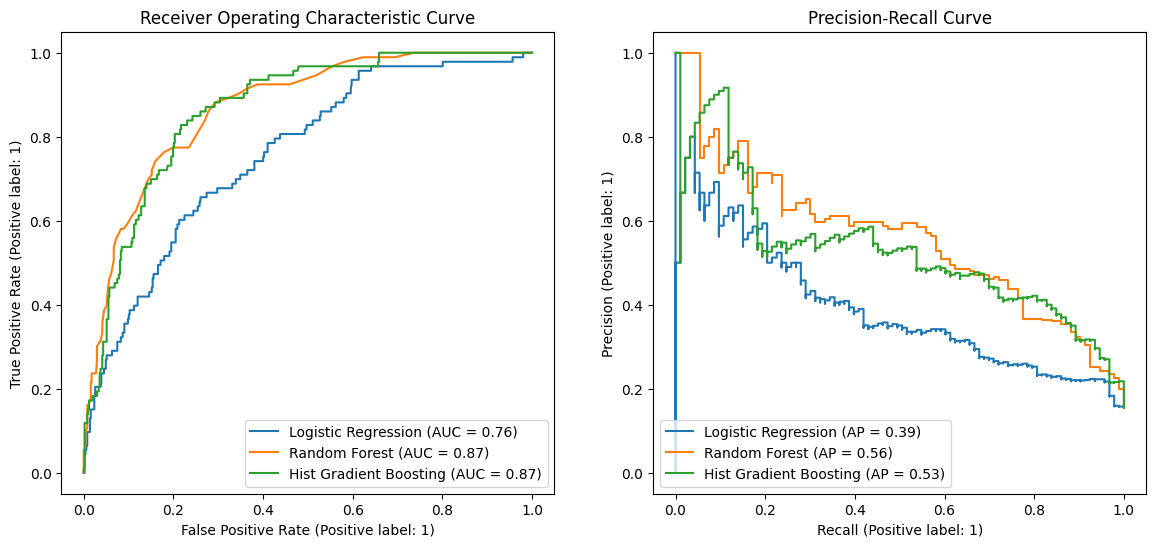

In [28]:
# Criar graficos das curvas ROC e PRC
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))

display_roc = RocCurveDisplay.from_estimator(pipe_lr, X_test, y_test, name="Logistic Regression", ax=ax[0])
display_roc = RocCurveDisplay.from_estimator(pipe_rf, X_test, y_test, name="Random Forest", ax=ax[0])
display_roc = RocCurveDisplay.from_estimator(pipe_hgb, X_test, y_test, name="Hist Gradient Boosting", ax=ax[0])
_ = display_roc.ax_.set_title("Receiver Operating Characteristic Curve")

display_prc = PrecisionRecallDisplay.from_estimator(pipe_lr, X_test, y_test, name="Logistic Regression", ax=ax[1])
display_prc = PrecisionRecallDisplay.from_estimator(pipe_rf, X_test, y_test, name="Random Forest", ax=ax[1])
display_prc = PrecisionRecallDisplay.from_estimator(pipe_hgb, X_test, y_test, name="Hist Gradient Boosting", ax=ax[1])
_ = display_prc.ax_.set_title("Precision-Recall Curve")
plt.show();

### Avaliação de Negócio do Modelo na Base de Teste

Qualquer modelo que construirmos terá que ser comparado com os modelos baseline para ver se o modelo é justo em seu desempenho:

- Modelo Aleatório (Random Model): O modelo de linha de base será um modelo aleatório, o que significa que é tão bom quanto o lançamento de uma moeda, o que significa que há 50% de probabilidade de que a ligação para um cliente seja positiva/o cliente compre nosso produto. O desempenho do nosso modelo de regressão logística deveria obviamente ser melhor do que isso.

- Modelo Wizard (Wizard Model): Este é o outro modelo extremo que é perfeito em sua previsão, o que significa que prevê quase 100% de precisão. Este modelo nunca deve ser usado na produção ou para qualquer decisão de negócios, pois há uma grande chance de overfitting.

Visualizaremos os modelos acima nos seguintes gráficos abaixo:

- Lift Plot: Mede a razão entre o número de observações positivas até o decil i usando o modelo e o número esperado de positivas até aquele decil i com base em um modelo aleatório. Gráfico de elevação é o gráfico entre a elevação no eixo vertical e o decil correspondente no eixo horizontal.

- Cumulative Gain Plot: Mede a razão entre o número cumulativo de observações positivas até um decil e o número total de observações positivas nos dados. O gráfico de ganho é um gráfico desenhado entre o ganho acumulado no eixo vertical e o decil no eixo horizontal.

- Decile-Wise Lift Plot: Nos mostra a porcentagem de observação da classe alvo em cada um dos decis.

- KS Statistic Plot: O gráfico KS avalia diferentes distribuições, ou seja, eventos e não eventos, e o valor KS é um ponto onde a diferença é máxima entre as distribuições. Resumindo, ajuda-nos a compreender a capacidade do modelo ML de diferenciar dois eventos.

In [29]:
# Utilizar modelos de machine learning treinados e aplicar as "probabilidades" no conjunto de testes
y_pred_proba_test_lr = pipe_lr.predict_proba(X_test)[:, 1]
y_pred_proba_test_rf = pipe_rf.predict_proba(X_test)[:, 1]
y_pred_proba_test_hgb = pipe_hgb.predict_proba(X_test)[:, 1]

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.725,0.960,0.825,60.000,27.000,33.000,9.300,60,45.000,60.000,27.000,60,33.000,10.000,29.032,64.516,6.509,22.523,2.903
1,2,0.588,0.722,0.648,60.000,15.000,45.000,9.300,33,25.000,120.000,42.000,93,78.000,20.000,45.161,100.000,15.385,29.776,2.258
2,3,0.505,0.586,0.548,60.000,15.000,45.000,9.300,0,25.000,180.000,57.000,93,123.000,30.000,61.290,100.000,24.260,37.030,2.043
3,4,0.442,0.504,0.474,60.000,8.000,52.000,9.300,0,13.333,240.000,65.000,93,175.000,40.000,69.892,100.000,34.517,35.375,1.747
4,5,0.382,0.442,0.412,60.000,10.000,50.000,9.300,0,16.667,300.000,75.000,93,225.000,50.000,80.645,100.000,44.379,36.266,1.613
5,6,0.343,0.382,0.360,60.000,5.000,55.000,9.300,0,8.333,360.000,80.000,93,280.000,60.000,86.022,100.000,55.227,30.795,1.434
6,7,0.290,0.343,0.320,60.000,10.000,50.000,9.300,0,16.667,420.000,90.000,93,330.000,70.000,96.774,100.000,65.089,31.685,1.382
7,8,0.219,0.290,0.254,60.000,0.000,60.000,9.300,0,0.000,480.000,90.000,93,390.000,80.000,96.774,100.000,76.923,19.851,1.210
8,9,0.167,0.219,0.193,60.000,1.000,59.000,9.300,0,1.667,540.000,91.000,93,449.000,90.000,97.849,100.000,88.560,9.289,1.087
9,10,0.017,0.166,0.133,60.000,2.000,58.000,9.300,0,3.333,600.000,93.000,93,507.000,100.000,100.000,100.000,100.000,0.000,1.000


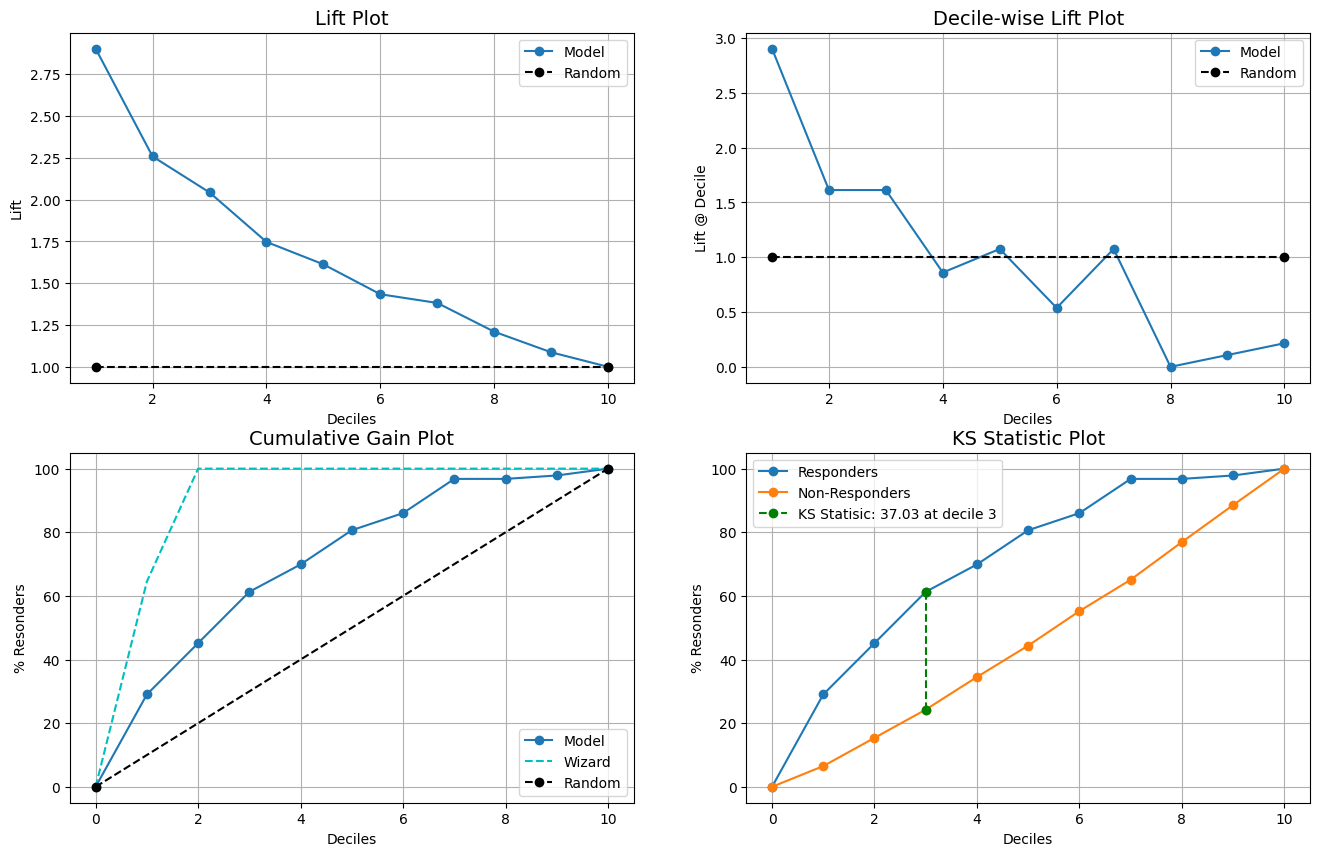

In [30]:
kds.metrics.report(y_test, y_pred_proba_test_lr)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.352,0.816,0.487,60.000,36.000,24.000,9.300,60,60.000,60.000,36.000,60,24.000,10.000,38.710,64.516,4.734,33.976,3.871
1,2,0.248,0.352,0.298,60.000,23.000,37.000,9.300,33,38.333,120.000,59.000,93,61.000,20.000,63.441,100.000,12.032,51.409,3.172
2,3,0.184,0.248,0.211,60.000,13.000,47.000,9.300,0,21.667,180.000,72.000,93,108.000,30.000,77.419,100.000,21.302,56.117,2.581
3,4,0.136,0.184,0.158,60.000,11.000,49.000,9.300,0,18.333,240.000,83.000,93,157.000,40.000,89.247,100.000,30.966,58.281,2.231
4,5,0.096,0.136,0.117,60.000,3.000,57.000,9.300,0,5.000,300.000,86.000,93,214.000,50.000,92.473,100.000,42.209,50.264,1.849
5,6,0.072,0.096,0.082,60.000,3.000,57.000,9.300,0,5.000,360.000,89.000,93,271.000,60.000,95.699,100.000,53.452,42.247,1.595
6,7,0.048,0.072,0.059,60.000,3.000,57.000,9.300,0,5.000,420.000,92.000,93,328.000,70.000,98.925,100.000,64.694,34.231,1.413
7,8,0.024,0.048,0.034,60.000,1.000,59.000,9.300,0,1.667,480.000,93.000,93,387.000,80.000,100.000,100.000,76.331,23.669,1.250
8,9,0.008,0.024,0.015,60.000,0.000,60.000,9.300,0,0.000,540.000,93.000,93,447.000,90.000,100.000,100.000,88.166,11.834,1.111
9,10,0.000,0.008,0.003,60.000,0.000,60.000,9.300,0,0.000,600.000,93.000,93,507.000,100.000,100.000,100.000,100.000,0.000,1.000


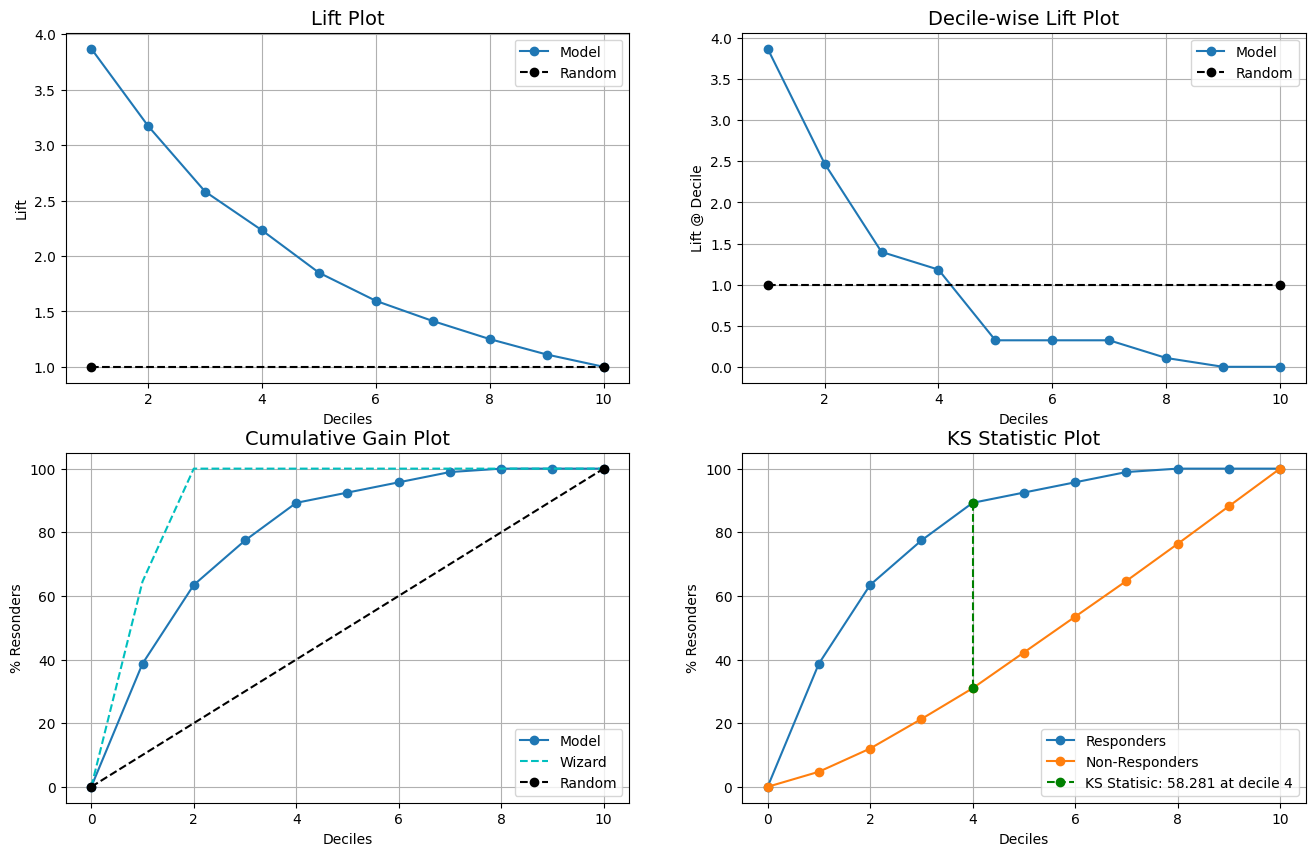

In [31]:
kds.metrics.report(y_test, y_pred_proba_test_rf)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.735,0.999,0.907,60.000,34.000,26.000,9.300,60,56.667,60.000,34.000,60,26.000,10.000,36.559,64.516,5.128,31.431,3.656
1,2,0.139,0.731,0.348,60.000,23.000,37.000,9.300,33,38.333,120.000,57.000,93,63.000,20.000,61.290,100.000,12.426,48.864,3.064
2,3,0.032,0.130,0.075,60.000,18.000,42.000,9.300,0,30.000,180.000,75.000,93,105.000,30.000,80.645,100.000,20.710,59.935,2.688
3,4,0.012,0.032,0.021,60.000,8.000,52.000,9.300,0,13.333,240.000,83.000,93,157.000,40.000,89.247,100.000,30.966,58.281,2.231
4,5,0.004,0.012,0.007,60.000,5.000,55.000,9.300,0,8.333,300.000,88.000,93,212.000,50.000,94.624,100.000,41.815,52.809,1.892
5,6,0.001,0.004,0.002,60.000,2.000,58.000,9.300,0,3.333,360.000,90.000,93,270.000,60.000,96.774,100.000,53.254,43.520,1.613
6,7,0.001,0.001,0.001,60.000,0.000,60.000,9.300,0,0.000,420.000,90.000,93,330.000,70.000,96.774,100.000,65.089,31.685,1.382
7,8,0.000,0.000,0.000,60.000,3.000,57.000,9.300,0,5.000,480.000,93.000,93,387.000,80.000,100.000,100.000,76.331,23.669,1.250
8,9,0.000,0.000,0.000,60.000,0.000,60.000,9.300,0,0.000,540.000,93.000,93,447.000,90.000,100.000,100.000,88.166,11.834,1.111
9,10,0.000,0.000,0.000,60.000,0.000,60.000,9.300,0,0.000,600.000,93.000,93,507.000,100.000,100.000,100.000,100.000,0.000,1.000


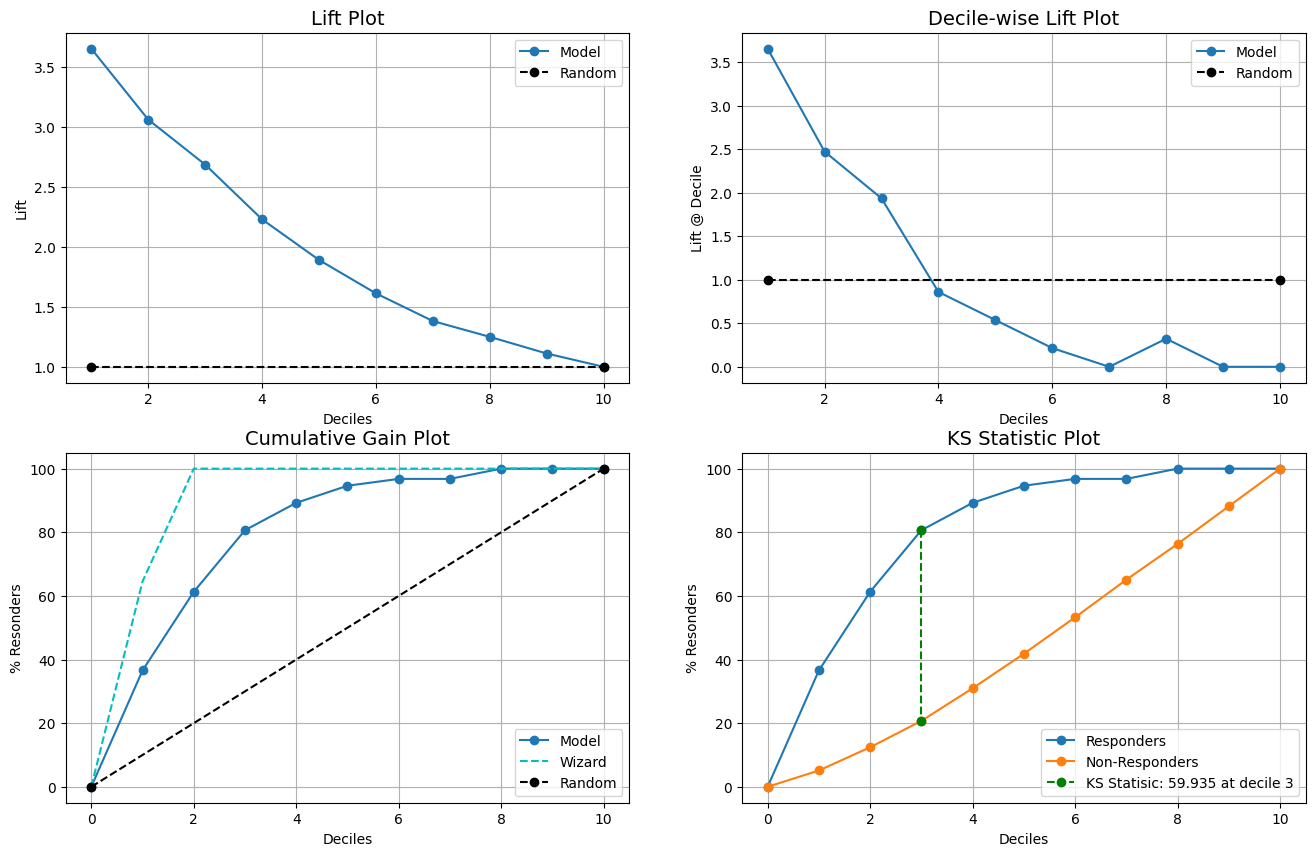

In [32]:
kds.metrics.report(y_test, y_pred_proba_test_hgb)

### Calibração dos Modelos - Venn-ABERS Predictions

O código abaixo consiste em:

1) Obter as “probabilidades” do modelo (“predict_proba”) no conjunto de calibração (“X_calib”, “y_calib”)
2) Gerar uma lista de pares (score, label) correspondentes aos scores do “predict_proba” e as labels originais da amostra de calibração.
3) O modelo de Venn-ABERS “aprende” a calibrar no conjunto de calibração, e compara a saída de pontuação pelo modelo de ML e comparando-os com rótulos de classe no conjunto de calibração
4) Por fim, obter a log-loss das previsões de Venn-ABERS (“p0”, “p1”)

In [33]:
# Use trained machine learning model to predict the "probabilities" on the calibration and test set
y_pred_proba_calib_lr = pipe_lr.predict_proba(X_calib)[:, 1]
y_pred_proba_calib_rf = pipe_rf.predict_proba(X_calib)[:, 1]
y_pred_proba_calib_hgb = pipe_hgb.predict_proba(X_calib)[:, 1]

In [34]:
#calibrPts: a list of pairs (score, label) corresponding to the scores and labels of the calibration examples.
# The score is a float and the label is an integer meant to take values 0 or 1.
lr_calib_points = list(zip(y_pred_proba_calib_lr, y_calib))

# Conformal Prediciton VennABERS calibration model learns calibration
# on the calibration dataset by comparing scores output by underlying machine
# learning model and comparing them with class labels on the calibration set
lr_p0, lr_p1 = VennABERS.ScoresToMultiProbs(lr_calib_points, y_pred_proba_test_lr)

# Get log-loss of Venn-ABERS Predictions
lr_log_loss_VA = lr_p1/(1-lr_p0+lr_p1)

In [35]:
#calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples.
# The score is a float and the label is an integer meant to take values 0 or 1.
rf_calib_points = list(zip(y_pred_proba_calib_rf, y_calib))

# Conformal Prediciton VennABERS calibration model learns calibration
# on the calibration dataset by comparing scores output by underlying machine
# learning model and comparing them with class labels on the calibration set
rf_p0, rf_p1 = VennABERS.ScoresToMultiProbs(rf_calib_points, y_pred_proba_test_rf)

# Get log-loss of Venn-ABERS Predictions
rf_log_loss_VA = rf_p1/(1-rf_p0+rf_p1)

In [36]:
# Get the predict class from the model
#calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples.
# The score is a float and the label is an integer meant to take values 0 or 1.
hgb_calib_points = list(zip(y_pred_proba_calib_hgb, y_calib))

# Conformal Prediciton VennABERS calibration model learns calibration
# on the calibration dataset by comparing scores output by underlying machine
# learning model and comparing them with class labels on the calibration set
hgb_p0, hgb_p1 = VennABERS.ScoresToMultiProbs(hgb_calib_points, y_pred_proba_test_hgb)

# Get log-loss of Venn-ABERS Predictions
hgb_log_loss_VA = hgb_p1/(1-hgb_p0+hgb_p1)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.345,0.667,0.452,60.000,27.000,33.000,9.300,60,45.000,60.000,27.000,60,33.000,10.000,29.032,64.516,6.509,22.523,2.903
1,2,0.250,0.345,0.284,60.000,15.000,45.000,9.300,33,25.000,120.000,42.000,93,78.000,20.000,45.161,100.000,15.385,29.776,2.258
2,3,0.197,0.250,0.229,60.000,15.000,45.000,9.300,0,25.000,180.000,57.000,93,123.000,30.000,61.290,100.000,24.260,37.030,2.043
3,4,0.094,0.189,0.131,60.000,8.000,52.000,9.300,0,13.333,240.000,65.000,93,175.000,40.000,69.892,100.000,34.517,35.375,1.747
4,5,0.085,0.094,0.091,60.000,10.000,50.000,9.300,0,16.667,300.000,75.000,93,225.000,50.000,80.645,100.000,44.379,36.266,1.613
5,6,0.066,0.085,0.078,60.000,7.000,53.000,9.300,0,11.667,360.000,82.000,93,278.000,60.000,88.172,100.000,54.832,33.340,1.470
6,7,0.062,0.066,0.066,60.000,8.000,52.000,9.300,0,13.333,420.000,90.000,93,330.000,70.000,96.774,100.000,65.089,31.685,1.382
7,8,0.057,0.062,0.060,60.000,0.000,60.000,9.300,0,0.000,480.000,90.000,93,390.000,80.000,96.774,100.000,76.923,19.851,1.210
8,9,0.047,0.057,0.048,60.000,1.000,59.000,9.300,0,1.667,540.000,91.000,93,449.000,90.000,97.849,100.000,88.560,9.289,1.087
9,10,0.025,0.047,0.039,60.000,2.000,58.000,9.300,0,3.333,600.000,93.000,93,507.000,100.000,100.000,100.000,100.000,0.000,1.000


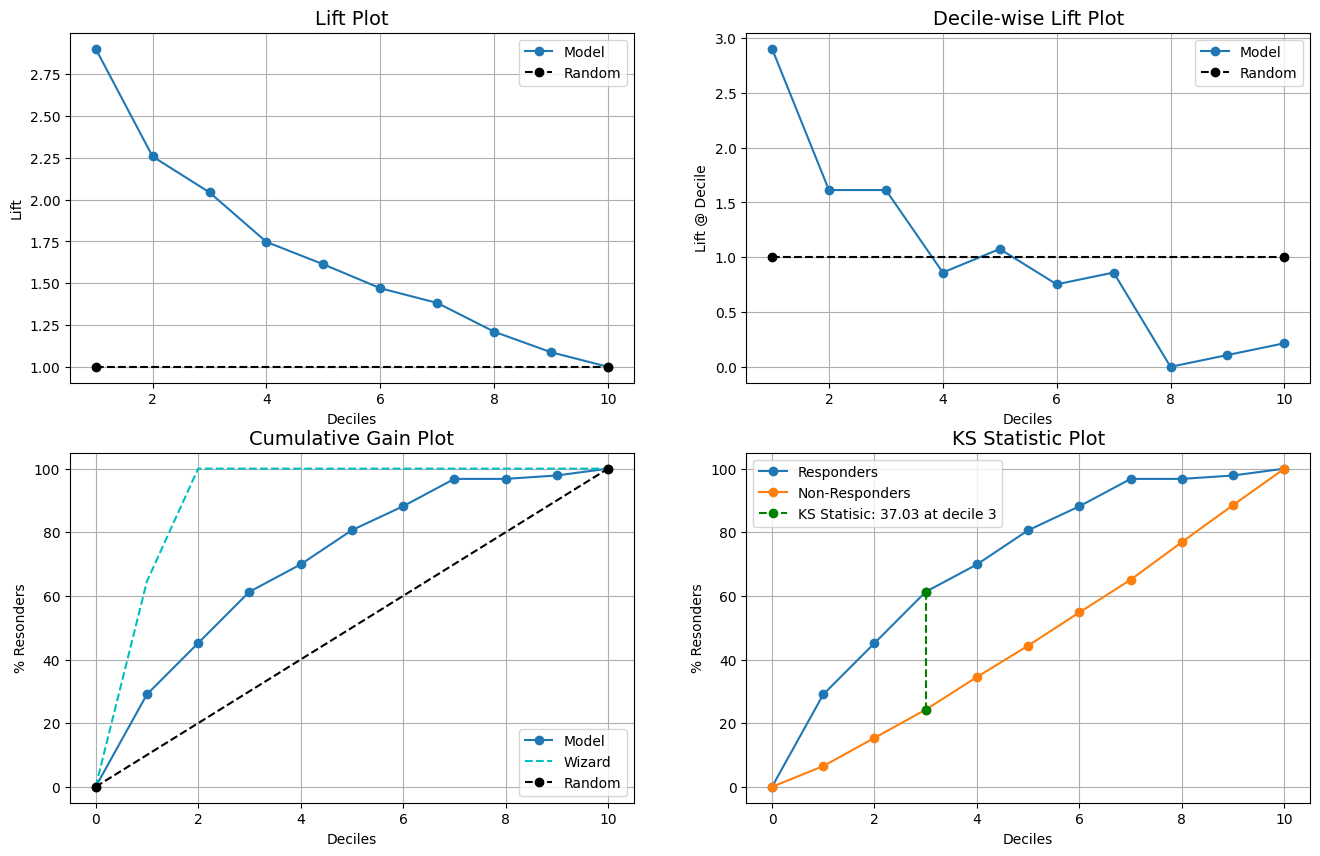

In [37]:
kds.metrics.report(y_test, lr_log_loss_VA)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.318,0.750,0.526,60.000,37.000,23.000,9.300,60,61.667,60.000,37.000,60,23.000,10.000,39.785,64.516,4.536,35.249,3.978
1,2,0.293,0.318,0.303,60.000,21.000,39.000,9.300,33,35.000,120.000,58.000,93,62.000,20.000,62.366,100.000,12.229,50.137,3.118
2,3,0.192,0.293,0.234,60.000,14.000,46.000,9.300,0,23.333,180.000,72.000,93,108.000,30.000,77.419,100.000,21.302,56.117,2.581
3,4,0.127,0.192,0.144,60.000,11.000,49.000,9.300,0,18.333,240.000,83.000,93,157.000,40.000,89.247,100.000,30.966,58.281,2.231
4,5,0.067,0.127,0.091,60.000,3.000,57.000,9.300,0,5.000,300.000,86.000,93,214.000,50.000,92.473,100.000,42.209,50.264,1.849
5,6,0.057,0.067,0.059,60.000,2.000,58.000,9.300,0,3.333,360.000,88.000,93,272.000,60.000,94.624,100.000,53.649,40.975,1.577
6,7,0.049,0.057,0.054,60.000,4.000,56.000,9.300,0,6.667,420.000,92.000,93,328.000,70.000,98.925,100.000,64.694,34.231,1.413
7,8,0.047,0.049,0.049,60.000,1.000,59.000,9.300,0,1.667,480.000,93.000,93,387.000,80.000,100.000,100.000,76.331,23.669,1.250
8,9,0.032,0.047,0.043,60.000,0.000,60.000,9.300,0,0.000,540.000,93.000,93,447.000,90.000,100.000,100.000,88.166,11.834,1.111
9,10,0.015,0.032,0.022,60.000,0.000,60.000,9.300,0,0.000,600.000,93.000,93,507.000,100.000,100.000,100.000,100.000,0.000,1.000


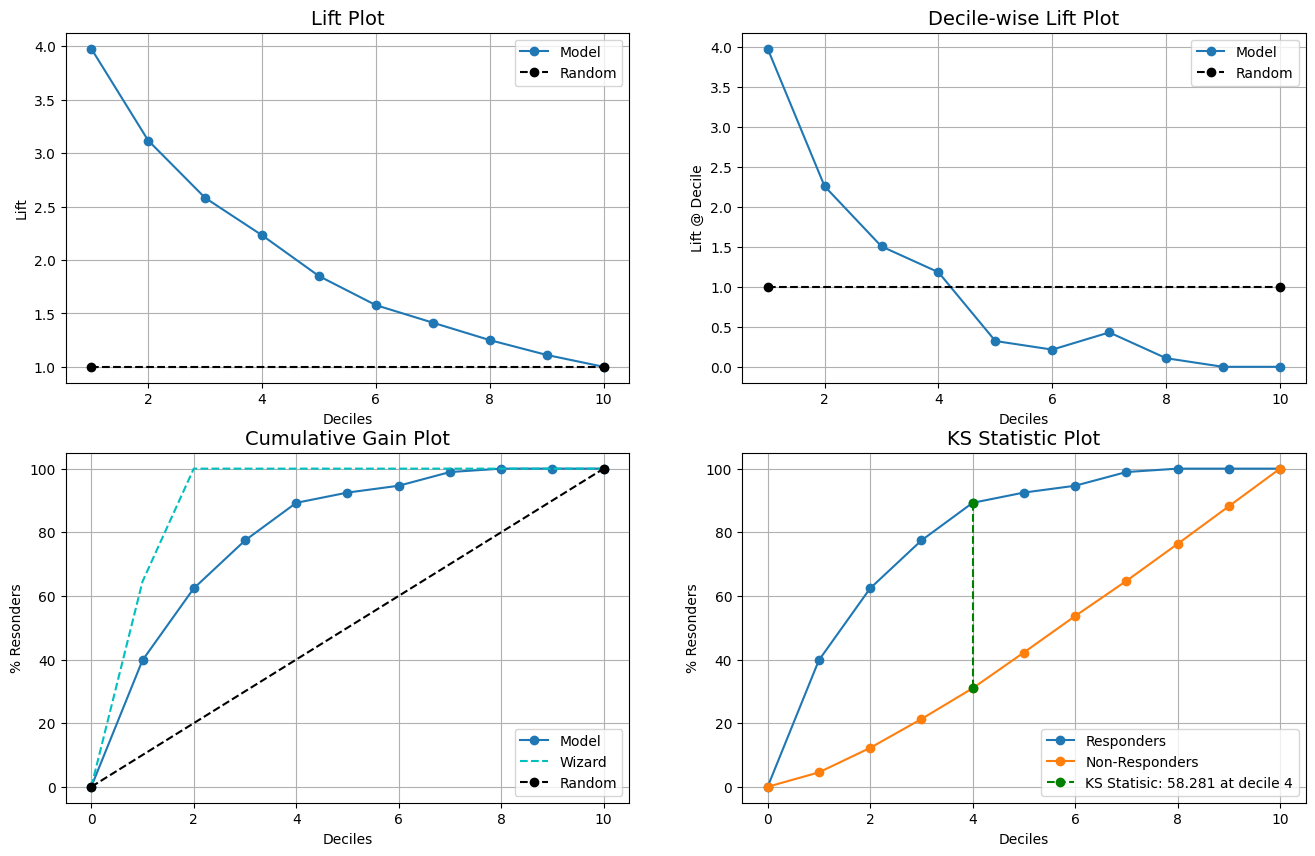

In [38]:
kds.metrics.report(y_test, rf_log_loss_VA)

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.366,0.769,0.566,60.000,33.000,27.000,9.300,60,55.000,60.000,33.000,60,27.000,10.000,35.484,64.516,5.325,30.159,3.548
1,2,0.209,0.366,0.267,60.000,26.000,34.000,9.300,33,43.333,120.000,59.000,93,61.000,20.000,63.441,100.000,12.032,51.409,3.172
2,3,0.203,0.209,0.209,60.000,16.000,44.000,9.300,0,26.667,180.000,75.000,93,105.000,30.000,80.645,100.000,20.710,59.935,2.688
3,4,0.124,0.203,0.175,60.000,6.000,54.000,9.300,0,10.000,240.000,81.000,93,159.000,40.000,87.097,100.000,31.361,55.736,2.177
4,5,0.081,0.124,0.105,60.000,7.000,53.000,9.300,0,11.667,300.000,88.000,93,212.000,50.000,94.624,100.000,41.815,52.809,1.892
5,6,0.040,0.081,0.063,60.000,2.000,58.000,9.300,0,3.333,360.000,90.000,93,270.000,60.000,96.774,100.000,53.254,43.520,1.613
6,7,0.036,0.040,0.038,60.000,1.000,59.000,9.300,0,1.667,420.000,91.000,93,329.000,70.000,97.849,100.000,64.892,32.957,1.398
7,8,0.030,0.036,0.033,60.000,2.000,58.000,9.300,0,3.333,480.000,93.000,93,387.000,80.000,100.000,100.000,76.331,23.669,1.250
8,9,0.018,0.030,0.023,60.000,0.000,60.000,9.300,0,0.000,540.000,93.000,93,447.000,90.000,100.000,100.000,88.166,11.834,1.111
9,10,0.009,0.018,0.014,60.000,0.000,60.000,9.300,0,0.000,600.000,93.000,93,507.000,100.000,100.000,100.000,100.000,0.000,1.000


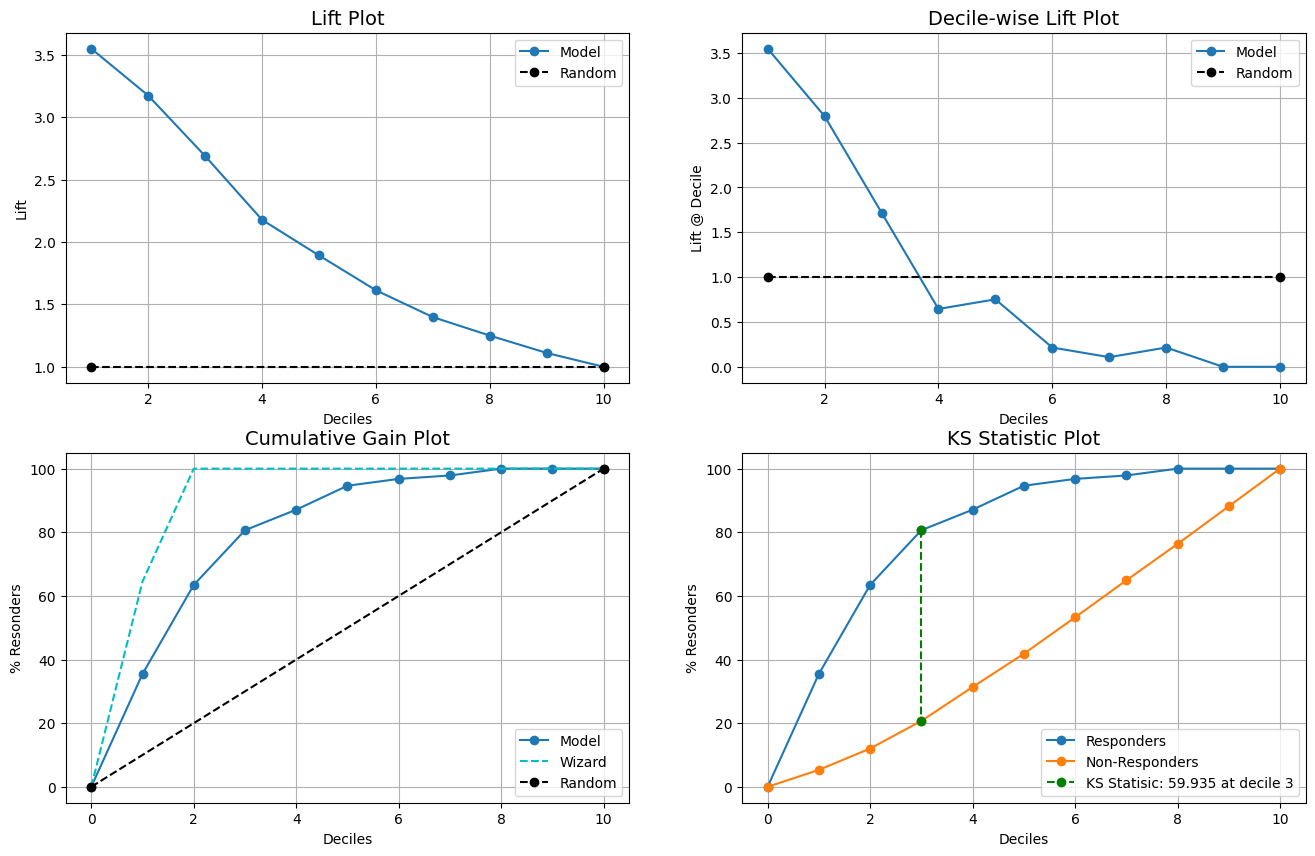

In [39]:
kds.metrics.report(y_test, hgb_log_loss_VA)

Para finalizar, vamos comparar o score gerado pela log-loss das previsões de Venn-ABERS (“p0”, “p1”) com o score gerado pré-calibração do “predict_proba”. A sequência de códigos abaixo irá agrupar ambos scores por percentis (aqui usarei decis), e vamos calcular a taxa de default acumulada para cada faixa de 1 à 10.

Afinal, uma probabilidade predita bem calibarada, de digamos, >=0,90 deveria ter frequência acumulada verdadeira de ter pelo menos 90% dos maus pagadores.

Para começar, vamos criar a função abaixo para gerar as frequências de acordo com os percentis do score.

In [40]:
# Function to calculate event rate per percentile

def quantile_table(data, var, target, quantile):

    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[var].rank(method='first'), quantile)
    grouped = data.groupby('bucket', as_index = False)
    
    quantile_table = pd.DataFrame()
    quantile_table['min_var'] = grouped.min()[var]
    quantile_table['max_var'] = grouped.max()[var]
    quantile_table['mean_var'] = grouped.mean()[var]

    quantile_table = quantile_table.sort_values(by="min_var").reset_index(drop = True)
    quantile_table['events']   = grouped.sum()[target]
    quantile_table['non_events'] = grouped.sum()['target0']
    quantile_table['total'] = quantile_table.events + quantile_table.non_events
    
    quantile_table['event_rate'] = (quantile_table.events/quantile_table.total)
    quantile_table['non_event_rate'] = (quantile_table.non_events/quantile_table.total)

    quantile_table['cumsum_events'] = (quantile_table.events.cumsum())
    quantile_table['cumsum_non_events'] = (quantile_table.non_events.cumsum())
    quantile_table['cumsum_total'] = (quantile_table.total.cumsum())
    quantile_table['cumsum_event_rate'] = (round(quantile_table.cumsum_events/quantile_table['events'].sum(), 2))

    quantile_table.index = range(1, quantile+1)
    quantile_table.index.rename('Quantiles', inplace=True)
    quantile_table = quantile_table.reset_index()
    
    return quantile_table

In [41]:
df_scores = pd.DataFrame({
    'y_true' : y_calib,
    'lr_y_pred' : y_pred_proba_calib_lr,
    'lr_p0' : lr_p0,
    'lr_p1' : lr_p1,
    'lr_log_loss_VA' : lr_log_loss_VA,
    'rf_y_pred' : y_pred_proba_calib_rf,
    'rf_p0' : rf_p0,
    'rf_p1' : rf_p1,
    'rf_log_loss_VA' : rf_log_loss_VA,
    'hgb_y_pred' : y_pred_proba_calib_hgb,
    'hgb_p0' : hgb_p0,
    'hgb_p1' : hgb_p1,
    'hgb_log_loss_VA' : hgb_log_loss_VA
})

df_lr_pred = quantile_table(data=df_scores, target='y_true', var='lr_y_pred', quantile=10)
df_lr_p0 = quantile_table(data=df_scores, target='y_true', var='lr_p0', quantile=10)
df_lr_p1 = quantile_table(data=df_scores, target='y_true', var='lr_p1', quantile=10)
df_lr_calib = quantile_table(data=df_scores, target='y_true', var='lr_log_loss_VA', quantile=10)

df_rf_pred = quantile_table(data=df_scores, target='y_true', var='rf_y_pred', quantile=10)
df_rf_p0 = quantile_table(data=df_scores, target='y_true', var='rf_p0', quantile=10)
df_rf_p1 = quantile_table(data=df_scores, target='y_true', var='rf_p1', quantile=10)
df_rf_calib = quantile_table(data=df_scores, target='y_true', var='rf_log_loss_VA', quantile=10)

df_hgb_pred = quantile_table(data=df_scores, target='y_true', var='hgb_y_pred', quantile=10)
df_hgb_p0 = quantile_table(data=df_scores, target='y_true', var='hgb_p0', quantile=10)
df_hgb_p1 = quantile_table(data=df_scores, target='y_true', var='hgb_p1', quantile=10)
df_hgb_calib = quantile_table(data=df_scores, target='y_true', var='hgb_log_loss_VA', quantile=10)

E por fim, vamos comparar graficamente com um diagrama de calibração/confiabilidade (“realiability”). São maneiras de ilustrar as propriedades das previsões probabilísticas. Eles consistem em um gráfico da frequência relativa observada contra a probabilidade prevista, fornecendo uma comparação visual da capacidade de calibração do modelo.

Podemos ver que, para os três modelos, a Uncalibrated Score (linha preta) é possivelmente menos precisa do que a calibração de Venn-ABERS (linha azul). Nota-se uma grande distância entre os decis nas altas probabilidades.

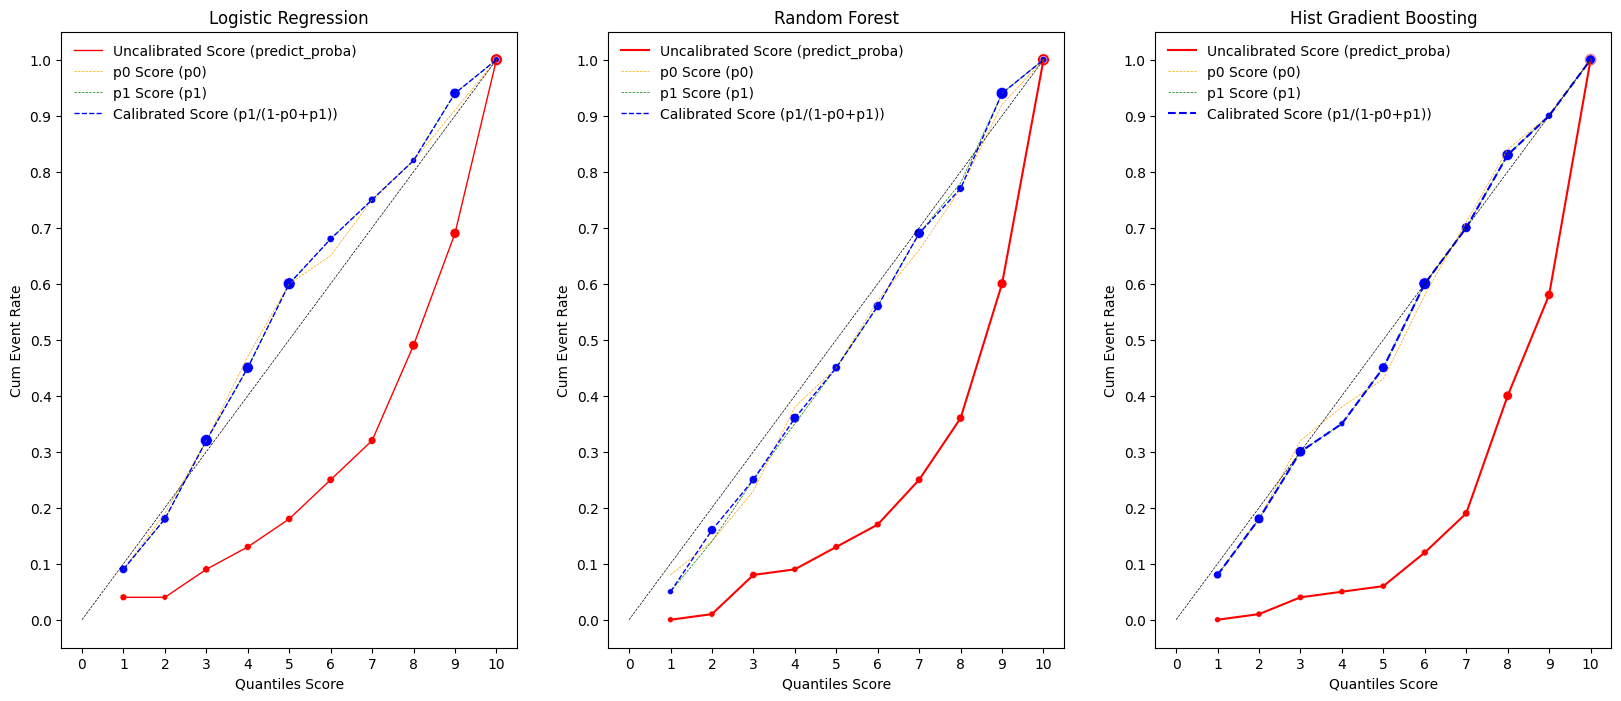

In [42]:
# Compare all scores
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20, 8))

x_values = [0,1,2,3,4,5,6,7,8,9,10]
y_values = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

sns.lineplot(x=df_lr_pred['Quantiles'], y=df_lr_pred['cumsum_event_rate'], linewidth=1, color='red', ax=ax[0], label="Uncalibrated Score (predict_proba)")
sns.lineplot(x=df_lr_p0['Quantiles'], y=df_lr_p0['cumsum_event_rate'], linewidth=0.5, color='orange', linestyle='--', ax=ax[0], label="p0 Score (p0)")
sns.lineplot(x=df_lr_p1['Quantiles'], y=df_lr_p1['cumsum_event_rate'], linewidth=0.5, color='green', linestyle='--', ax=ax[0], label="p1 Score (p1)")
sns.lineplot(x=df_lr_calib['Quantiles'], y=df_lr_calib['cumsum_event_rate'], linewidth=1, color='blue', linestyle='--', ax=ax[0], label="Calibrated Score (p1/(1-p0+p1))")
ax[0].plot([0, 10], [0, 1], linewidth=0.5, color='black', linestyle='--', label="Perfect Calibration")
sns.scatterplot(x=df_lr_pred['Quantiles'], y=df_lr_pred['cumsum_event_rate'], size=df_lr_pred['events'], color='red', marker='o', ax=ax[0])
sns.scatterplot(x=df_lr_calib['Quantiles'], y=df_lr_calib['cumsum_event_rate'], size=df_lr_calib['events'], color='blue', marker='o', ax=ax[0])
ax[0].set_xticks(x_values)
ax[0].set_yticks(y_values)
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h[0:4],l[0:14], loc='best', frameon=False)
ax[0].set_title('Logistic Regression')
ax[0].set_ylabel('Cum Event Rate')
ax[0].set_xlabel('Quantiles Score')

sns.lineplot(x=df_rf_pred['Quantiles'], y=df_rf_pred['cumsum_event_rate'], linewidth=1.5, color='red', ax=ax[1], label="Uncalibrated Score (predict_proba)")
sns.lineplot(x=df_rf_p0['Quantiles'], y=df_rf_p0['cumsum_event_rate'], linewidth=0.5, color='orange', linestyle='--', ax=ax[1], label="p0 Score (p0)")
sns.lineplot(x=df_rf_p1['Quantiles'], y=df_rf_p1['cumsum_event_rate'], linewidth=0.5, color='green', linestyle='--', ax=ax[1], label="p1 Score (p1)")
sns.lineplot(x=df_rf_calib['Quantiles'], y=df_rf_calib['cumsum_event_rate'], linewidth=1, color='blue', linestyle='--', ax=ax[1], label="Calibrated Score (p1/(1-p0+p1))")
ax[1].plot([0, 10], [0, 1], linewidth=0.5, color='black', linestyle='--', label="Perfect Calibration")
sns.scatterplot(x=df_rf_pred['Quantiles'], y=df_rf_pred['cumsum_event_rate'], size=df_rf_pred['events'], color='red', marker='o', ax=ax[1])
sns.scatterplot(x=df_rf_calib['Quantiles'], y=df_rf_calib['cumsum_event_rate'], size=df_rf_calib['events'], color='blue', marker='o', ax=ax[1])
ax[1].set_xticks(x_values)
ax[1].set_yticks(y_values)
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h[0:4],l[0:14], loc='best', frameon=False)
ax[1].set_title('Random Forest')
ax[1].set_ylabel('Cum Event Rate')
ax[1].set_xlabel('Quantiles Score')

sns.lineplot(x=df_hgb_pred['Quantiles'], y=df_hgb_pred['cumsum_event_rate'], linewidth=1.5, color='red', ax=ax[2], label="Uncalibrated Score (predict_proba)")
sns.lineplot(x=df_hgb_p0['Quantiles'], y=df_hgb_p0['cumsum_event_rate'], linewidth=0.5, color='orange', linestyle='--',  ax=ax[2], label="p0 Score (p0)")
sns.lineplot(x=df_hgb_p1['Quantiles'], y=df_hgb_p1['cumsum_event_rate'], linewidth=0.5, color='green', linestyle='--', ax=ax[2], label="p1 Score (p1)")
sns.lineplot(x=df_hgb_calib['Quantiles'], y=df_hgb_calib['cumsum_event_rate'], linewidth=1.5, color='blue', linestyle='--', ax=ax[2], label="Calibrated Score (p1/(1-p0+p1))")
ax[2].plot([0, 10], [0, 1], linewidth=0.5, color='black', linestyle='--', label="Perfect Calibration")
sns.scatterplot(x=df_hgb_pred['Quantiles'], y=df_hgb_pred['cumsum_event_rate'], size=df_hgb_pred['events'], color='red', marker='o', ax=ax[2])
sns.scatterplot(x=df_hgb_calib['Quantiles'], y=df_hgb_calib['cumsum_event_rate'], size=df_hgb_calib['events'], color='blue', marker='o', ax=ax[2])
ax[2].set_xticks(x_values)
ax[2].set_yticks(y_values)
h,l = ax[2].get_legend_handles_labels()
ax[2].legend(h[0:4],l[0:14], loc='best', frameon=False)
ax[2].set_title('Hist Gradient Boosting')
ax[2].set_ylabel('Cum Event Rate')
ax[2].set_xlabel('Quantiles Score')

plt.show();

# ----------------------------------------------------------------